In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

import seaborn as sns

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications import EfficientNetB0

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, classification_report, auc
from sklearn import metrics

from mlxtend.plotting import plot_confusion_matrix

#from google.colab import drive
#drive.mount('/content/drive')

Using TensorFlow backend.


# Loading the data

In [2]:
PATH = "./" #Donde estan los datos
NETWORK_PATH = "./" # Donde esta la red
MODEL_PATH = "./best_model_7.hdf5" # Donde se guardan los pesos
LOG_NAME = 'training_NoEscalado.log'
IMG_SIZE=224
BATCH_SIZE=60
EPOCHS = 10
METRICS = ['accuracy','mse','mae']

In [3]:
train_list_filenames=[]
train_list_labels=[]
dstpath= PATH + "train"
print(dstpath)
test_df = pd.read_csv(PATH + "test.txt", sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print(test_df.head())
train_txt= open(PATH+"train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(dstpath, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)

./train
                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0                             ./train\ARDSSevere.png  negative
1  ./train\acute-respiratory-distress-syndrome-ar...  negative
2  ./train\acute-respiratory-distress-syndrome-ar...  negative
3     ./train\ards-secondary-to-tiger-snake-bite.png  negative
4            ./train\pneumocystis-pneumonia-2-PA.png  negative
negative    13793
positive     2158
Name: labels, dtype: int64


In [4]:
file_count = 2158 #para cada clase
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

negative    2158
positive    2158
Name: labels, dtype: int64
4316


In [5]:
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)

In [6]:
print("Train set has a total of --{}-- instances and the validation set has --{}--".format(len(train_df),len(valid_df)))

Train set has a total of --3884-- instances and the validation set has --432--


## Image generation

In [7]:
gen=ImageDataGenerator()

In [ ]:
train_gen=gen.flow_from_dataframe( train_df, x_col='filenames', y_col='labels', target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=BATCH_SIZE)

In [8]:
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=BATCH_SIZE)

Found 432 validated image filenames belonging to 2 classes.


## Define steps 

In [ ]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 2
    else:
        return num_samples // batch_size

In [ ]:
nb_train_sample = train_df.shape[0] * 0.9
#nb_train_sample = 1165 * 0.9

nb_validation_sample = train_df.shape[0] - nb_train_sample
#nb_validation_sample = 1165 - nb_train_sample

nb_test_sample = valid_df.shape[0]
#nb_test_sample = 130

print(nb_train_sample)
print(nb_validation_sample)
print(nb_test_sample)

# Load the model

In [143]:
eff0 = EfficientNetB0( weights="imagenet", include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))

x = eff0.output 
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
predictions = Dense(2, activation='softmax')(x) # Determinamos salida a 10 clases
model = Model(inputs=eff0.input, outputs=predictions)

for layer in eff0.layers[:-200]:
    layer.trainable = False

optimizer = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.99, nesterov=True)
#optimizer = optimizers.RMSprop(learning_rate=0.0001)

model.build((None,IMG_SIZE,IMG_SIZE,3))
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=METRICS)

In [144]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

# Fit model

In [ ]:
callbacks1 = [
    EarlyStopping(monitor='val_loss',patience=2, mode='min', verbose=1, min_delta=1e-3),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, mode='min', verbose=1),
    ModelCheckpoint(filepath=MODEL_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    CSVLogger(LOG_NAME, append=False, separator=",")
    ]

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=get_steps(nb_train_sample, BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=valid_gen,
    validation_steps=get_steps(nb_validation_sample, BATCH_SIZE),
    verbose=1,
    callbacks=callbacks1
)

# Plot results

In [ ]:
def plotTraining(hist, epochs, typeData):
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        print(yc)
        xc=range(len(yc))
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(len(yc))
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(len(yc))
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(len(yc))
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
    if typeData=="mse":
        plt.figure(3,figsize=(10,5))
        yc=hist.history['mse']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(len(yc))
        plt.ylabel('mse (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='mse')
    if typeData=="mae":
        plt.figure(3,figsize=(10,5))
        yc=hist.history['mae']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(len(yc))
        plt.ylabel('mae (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='mae')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

plotTraining(history,EPOCHS,"loss")
plotTraining(history,EPOCHS,"accuracy")
plotTraining(history,EPOCHS,"val_loss")
plotTraining(history,EPOCHS,"val_accuracy")
plotTraining(history,EPOCHS,"mse")
plotTraining(history,EPOCHS,"mae")

### This section works, from a loaded model

In [96]:
predictions = model.predict_generator(valid_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [48]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set: EfficientNetB0')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix: EfficientNetB0")
        plt.savefig("CM.png")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

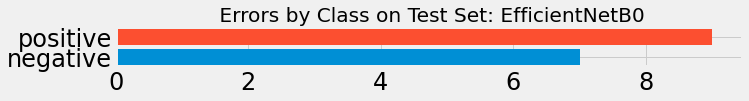

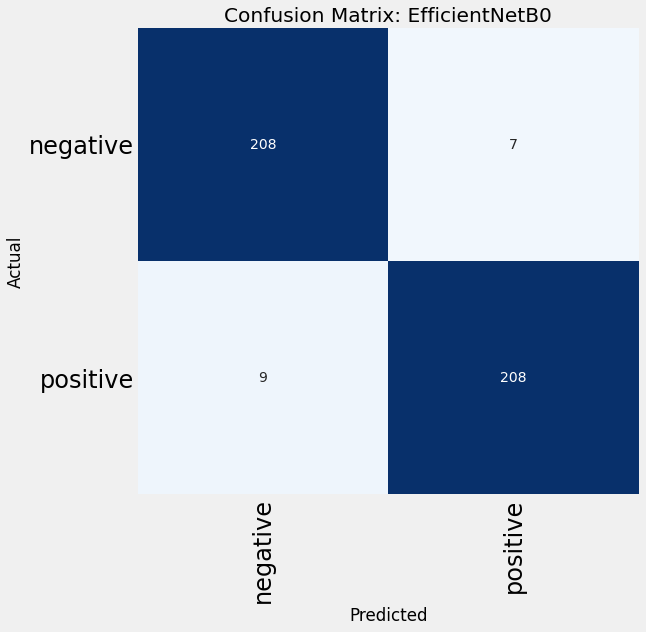

Classification Report:
----------------------
               precision    recall  f1-score   support

    negative       0.96      0.97      0.96       215
    positive       0.97      0.96      0.96       217

    accuracy                           0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432



In [49]:
print_code=0
preds=model.predict(valid_gen) 
print_info( valid_gen, preds, print_code, NETWORK_PATH, 'covid' )

In [20]:
valid_gen.reset()
preds = model.predict(valid_gen)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(valid_gen.classes, preds)
auc_rf = auc(fpr_rf, tpr_rf)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


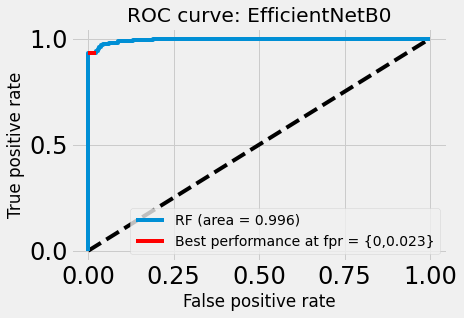

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


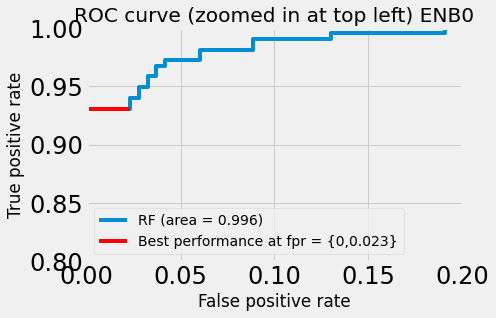

In [45]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot([0,0.02325581], [0.93087558,0.93087558], '-r',label="Best performance at fpr = {0,0.023}")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: EfficientNetB0')
plt.legend(loc='best')
plt.savefig("ROC1.eps")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot([0,0.02325581], [0.93087558,0.93087558], '-r',label="Best performance at fpr = {0,0.023}")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left) ENB0')
plt.legend(loc='best')
plt.savefig("ROC2.eps")
plt.show()

In [31]:
fpr_rf

array([0.        , 0.        , 0.        , 0.02325581, 0.02325581,
       0.02790698, 0.02790698, 0.03255814, 0.03255814, 0.0372093 ,
       0.0372093 , 0.04186047, 0.04186047, 0.06046512, 0.06046512,
       0.08837209, 0.08837209, 0.13023256, 0.13023256, 0.19069767,
       0.19069767, 1.        ])

# Save the model

In [ ]:
#model.save(NETWORK_PATH+"model_backup_EfficientNet.h5") #save model

#======== SAVE HISTORY =========


# convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history.history) 

# save to json:  
# hist_json_file = 'history.json' 
#with open(hist_json_file, mode='w') as f:
    #hist_df.to_json(f)
    
# save to csv: 
#hist_csv_file = 'history.csv'
#with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)

# Plot results from loaded model

In [9]:
import json
model = load_model(NETWORK_PATH+"best_model_6.hdf5") #load model
history = json.load(open("./history.json", 'r'))

In [10]:
qm=[] # loss, acc, mse, mae, val_loss, val_acc, val_mse, val_mae, lr
      # 0   , 1  , 2,   3,   4,        5,       6,       7,       8
for key, value in history.items():
    cm = []
    for k,v in value.items():
        cm.append(v)
    qm.append(cm)
qm = np.array(qm)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


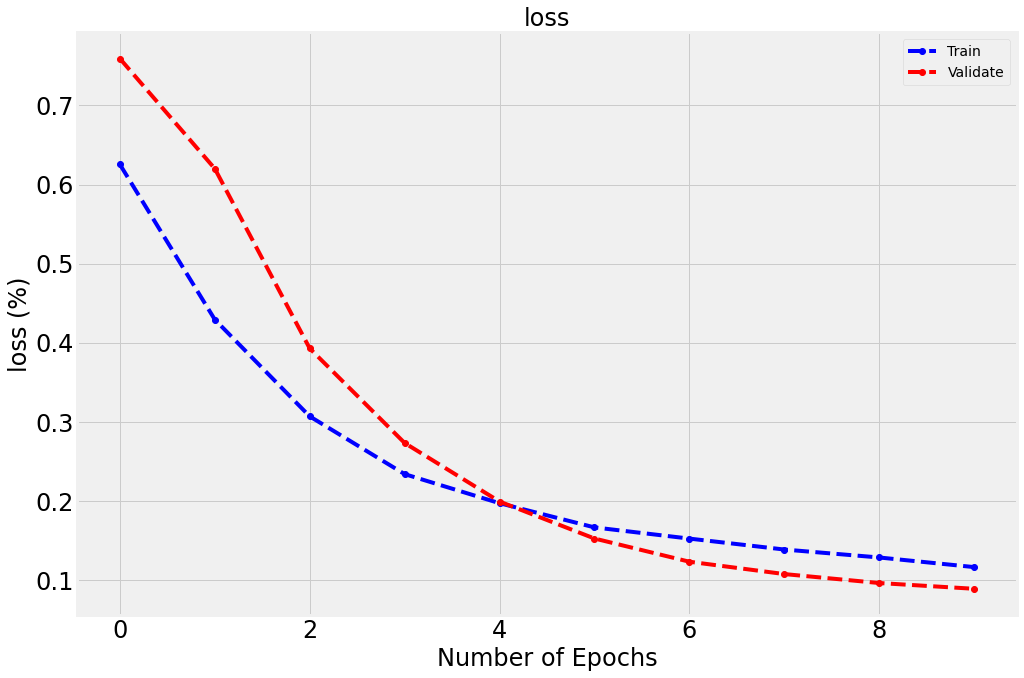

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


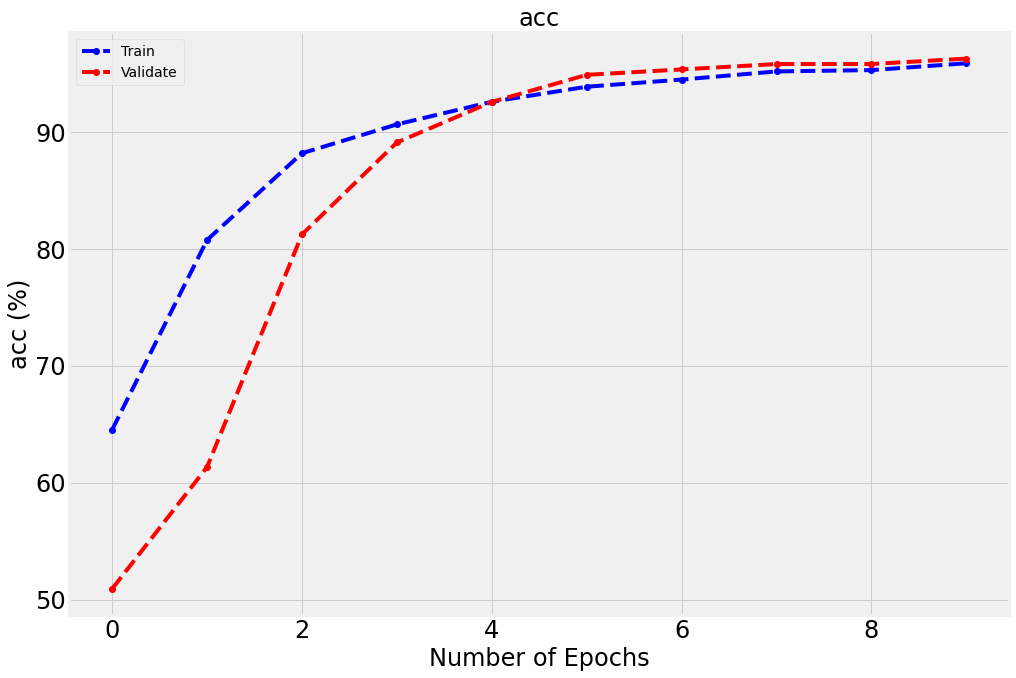

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


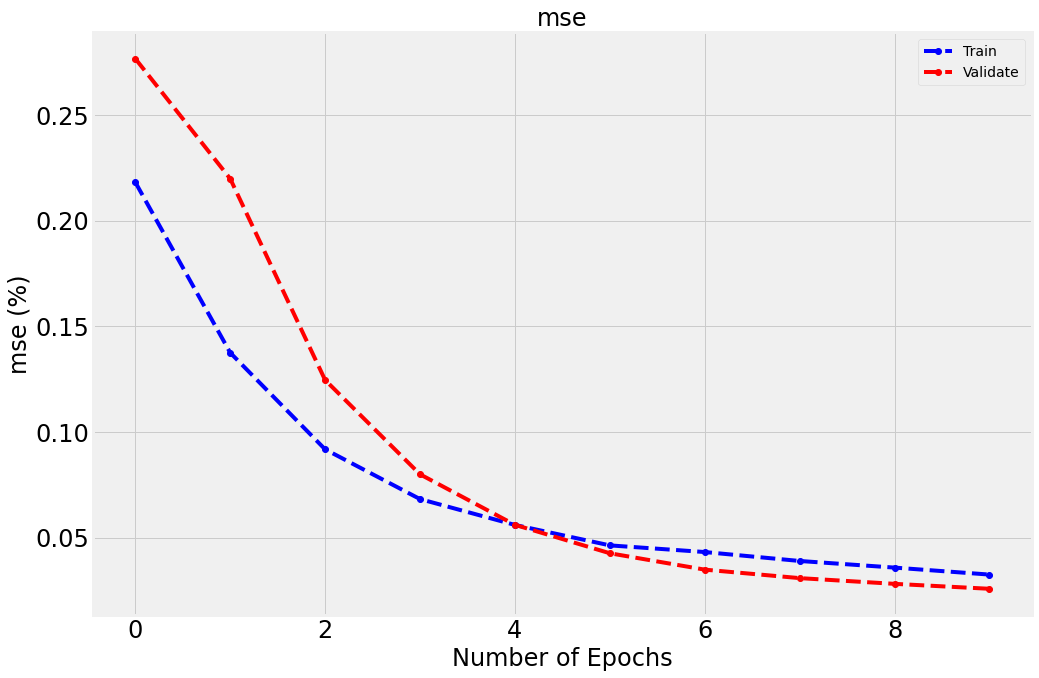

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


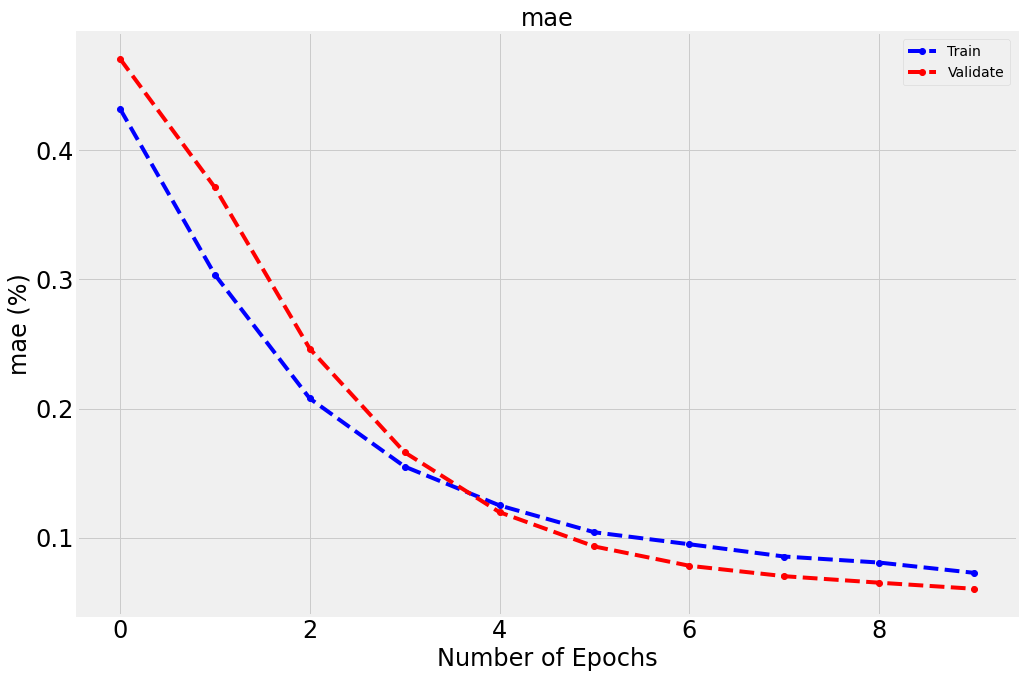

In [44]:
metric = ["loss", "acc", "mse", "mae", "val_loss", "val_acc", "val_mse", "val_mae", "lr"]
for j in range(4):        
    fig = plt.figure(1,figsize=(15,10))
    plt.plot(range(10),qm[j],'--bo',label="Train")
    plt.plot(range(10),qm[j+4],'--ro',label="Validate")
    plt.ylabel('{} (%)'.format(metric[j]), fontsize=24)
    plt.legend()
    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)
    fig.patch.set_facecolor('xkcd:white')
    plt.title(metric[j],fontsize=24 )
    plt.savefig("{}.eps".format(metric[j]))
    plt.show()